In [1]:
import pandas as pd
import numpy as np

from pandas.api.types import CategoricalDtype

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold,cross_val_score
import locale
from contextlib import contextmanager

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
@contextmanager
def setlocale(name):
    with_C = False
    try:
        saved = locale.setlocale(locale.LC_TIME, name)
        if saved == 'C':
            with_C = True
        yield
    finally:
        if with_C:
            locale.setlocale(locale.LC_TIME, saved)

In [5]:
data = pd.read_csv("C:\\Users\\iozcelik\\Desktop\\Cem Ozcelik İş Dosyaları\\Kişisel Çalışmalar\\Credit-Risk\\Credit-Risk\\notebook\\data\\lending_club_loan_two.csv")

In [6]:
df = data.copy()

In [7]:
df['loan_status_bin'] = np.where(df['loan_status'] == 'Fully Paid',0,1)

In [8]:
df['mort_acc'].fillna(df['mort_acc'].median(), inplace=True)
df['revol_util'].fillna(df['revol_util'].median(), inplace=True)
df['pub_rec_bankruptcies'].fillna(df['pub_rec_bankruptcies'].mode()[0], inplace=True)

In [9]:
df.loc[df['dti'] > df['dti'].quantile(0.99), 'dti'] = df['dti'].quantile(0.99)
df.loc[df['revol_bal'] > df['revol_bal'].quantile(0.95), 'revol_bal'] = df['revol_bal'].quantile(0.95)
df.loc[df['revol_util'] > df['revol_util'].quantile(0.99), 'revol_util'] = df['revol_util'].quantile(0.99)
df.loc[(df['int_rate']> df['int_rate'].quantile(0.99) ), 'int_rate'] = df['int_rate'].quantile(0.99)

df.loc[(df['installment']> df['installment'].quantile(0.99) ), 'installment'] = df['installment'].quantile(0.99)
df.loc[(df['annual_inc']> df['annual_inc'].quantile(0.95) ), 'annual_inc'] = df['annual_inc'].quantile(0.95)
df.loc[df['open_acc'] > df['open_acc'].quantile(0.99), 'open_acc'] = df['open_acc'].quantile(0.99)
df.loc[df['total_acc'] > df['total_acc'].quantile(0.97), 'total_acc'] = df['total_acc'].quantile(0.97)

In [10]:
df['loan_to_income'] = np.where(df['annual_inc'] == 0, 0, round((df['loan_amnt'] / df['annual_inc']), 4))

df['term_cat'] = df['term'].str.replace(' months', '')

with setlocale('en_US.UTF-8'):
    df['credit_history_length'] = round(( (
        pd.to_datetime(df['issue_d'], format='%b-%Y') - 
        pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
    ).dt.days / 365.25),4)

df['zipcode'] = df['address'].str.extract(r'(\d{5})$')

df['open_total_acc_rate'] = np.where(df['total_acc'] == 0,0, round((df['open_acc'] / df['total_acc']),4)  )
df['has_pub_rec'] = np.where(df['pub_rec'] > 0, 1, 0)
df['has_pub_rec_bank'] = np.where(df['pub_rec_bankruptcies'] > 0, 1, 0)

In [11]:
drop_cols = ['loan_status', 'loan_amnt','term','emp_title', 
            'emp_length', 'address', 'title', 'grade','issue_d', 
            'earliest_cr_line','address', 'total_acc', 'open_acc',
            'pub_rec', 'pub_rec_bankruptcies', 'loan_amnt', 'annual_inc']
df.drop(columns =drop_cols, inplace=True )

In [12]:
numerical_columns = [col for col in df.columns if str(df[col].dtype) in ['float64', 'int64', 'int32']]

categorical_columns = [col for col in df.columns if col not in numerical_columns]

In [13]:
print("Numerical Cols:", numerical_columns)
print("Categorical Cols:", categorical_columns)

Numerical Cols: ['int_rate', 'installment', 'dti', 'revol_bal', 'revol_util', 'mort_acc', 'loan_status_bin', 'loan_to_income', 'credit_history_length', 'open_total_acc_rate', 'has_pub_rec', 'has_pub_rec_bank']
Categorical Cols: ['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'term_cat', 'zipcode']


In [14]:
non_ord_vars = ['purpose', 'home_ownership', 'verification_status', 
                'initial_list_status','application_type', 'zipcode',
                'term_cat', 'has_pub_rec', 'has_pub_rec_bank'
                ]

ord_vars = [col for col in df.columns if col in categorical_columns and col not in non_ord_vars]

In [15]:
sub_grade_order = sorted(df['sub_grade'].unique())
sub_grade_map = {grade: i for i, grade in enumerate(sub_grade_order)}
df['sub_grade'] = df['sub_grade'].map(sub_grade_map)

In [17]:
list(df.columns)

['int_rate',
 'installment',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'dti',
 'revol_bal',
 'revol_util',
 'initial_list_status',
 'application_type',
 'mort_acc',
 'loan_status_bin',
 'loan_to_income',
 'term_cat',
 'credit_history_length',
 'zipcode',
 'open_total_acc_rate',
 'has_pub_rec',
 'has_pub_rec_bank']

In [14]:
df = pd.get_dummies(df, columns=non_ord_vars, drop_first=True)

In [15]:
X = df.drop('loan_status_bin', axis=1) 
y = df['loan_status_bin']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [16]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [17]:
for name, model in models.items():
    print("-" * 30)
    print(f"Model: {name}")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

------------------------------
Model: Random Forest

Accuracy: 0.8897

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94     63671
           1       0.95      0.46      0.62     15535

    accuracy                           0.89     79206
   macro avg       0.92      0.73      0.78     79206
weighted avg       0.90      0.89      0.87     79206

------------------------------
Model: Decision Tree

Accuracy: 0.8307

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     63671
           1       0.57      0.59      0.58     15535

    accuracy                           0.83     79206
   macro avg       0.73      0.74      0.74     79206
weighted avg       0.83      0.83      0.83     79206

------------------------------
Model: Gradient Boosting

Accuracy: 0.8893

Classification Report:
              precision    recall  f1-score   support

     

In [18]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"The scale_pos_weight value has calculated: {scale_pos_weight:.2f}")
print("-" * 30)

The scale_pos_weight value has calculated: 4.10
------------------------------


In [19]:
models_balanced = {
    
    "Random Forest (Balanced)": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Decision Tree (Balanced)": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    
    "XGBClassifier (Balanced)": XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42),
    "CatBoosting Classifier (Balanced)": CatBoostClassifier(scale_pos_weight=scale_pos_weight, verbose=False, random_state=42)
}


In [20]:
print("\n--- RESULTS OF BALANCED MODELS ---")
for name, model in models_balanced.items():
    print("-" * 30)
    print(f"Model: {name}")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


--- RESULTS OF BALANCED MODELS ---
------------------------------
Model: Random Forest (Balanced)

Accuracy: 0.8897

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     63671
           1       0.96      0.45      0.62     15535

    accuracy                           0.89     79206
   macro avg       0.92      0.73      0.78     79206
weighted avg       0.90      0.89      0.87     79206

------------------------------
Model: Decision Tree (Balanced)

Accuracy: 0.8354

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     63671
           1       0.58      0.59      0.58     15535

    accuracy                           0.84     79206
   macro avg       0.74      0.74      0.74     79206
weighted avg       0.84      0.84      0.84     79206

------------------------------
Model: XGBClassifier (Balanced)

Accuracy: 0.8104

Classification Rep

In [21]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'n_estimators': [100, 200, 500],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,  
    cv=5,
    scoring='f1', 
    n_jobs=-1,
    verbose=2, 
    random_state=42
)
print("\nHyperparameter optimization is starting... (This process may take some time)")
random_search.fit(X_train, y_train)


print("\nOptimization complete!")
print("The best parameters found:")
print(random_search.best_params_)

best_xgb_model = random_search.best_estimator_

y_pred_tuned = best_xgb_model.predict(X_test)

print("\n--- OPTIMIZED (TUNED) XGBClassifier RESULTS ---")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))


Hyperparameter optimization is starting... (This process may take some time)
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Optimization complete!
The best parameters found:
{'subsample': 1.0, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

--- OPTIMIZED (TUNED) XGBClassifier RESULTS ---

Accuracy: 0.8326

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     63671
           1       0.55      0.75      0.64     15535

    accuracy                           0.83     79206
   macro avg       0.74      0.80      0.76     79206
weighted avg       0.86      0.83      0.84     79206




Top 10 Features and Their Scores:
          Feature  Importance
40  zipcode_86630        0.21
41  zipcode_93700        0.19
33  zipcode_05113        0.19
36  zipcode_29597        0.18
34  zipcode_11650        0.17
35  zipcode_22690        0.01
39  zipcode_70466        0.01
37  zipcode_30723        0.01
2       sub_grade        0.01
38  zipcode_48052        0.00


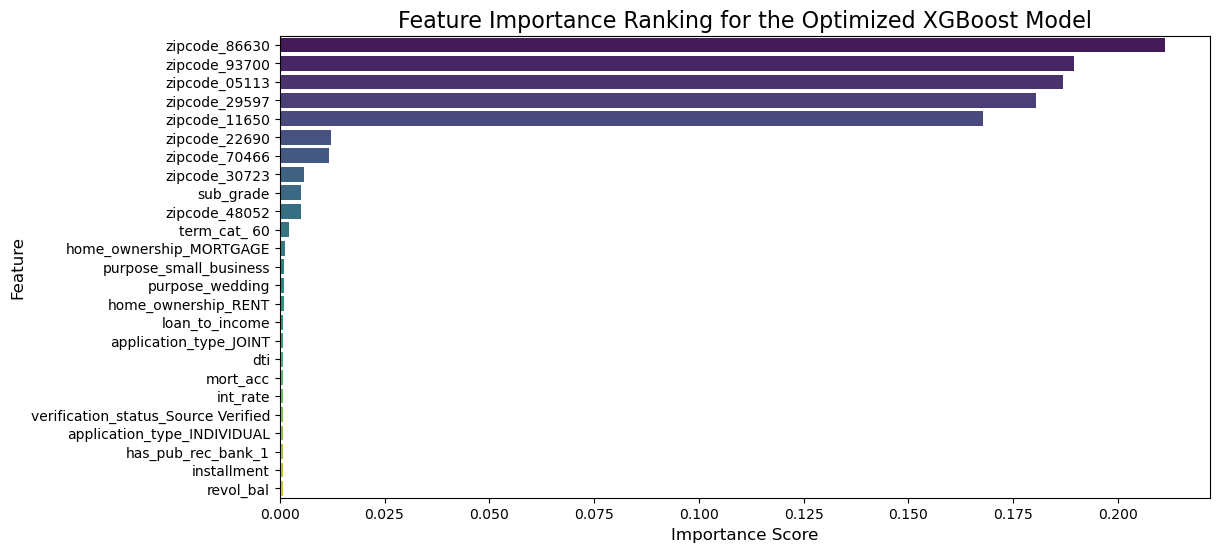

In [22]:
try:
    feature_importances = best_xgb_model.feature_importances_
    feature_names = X_train.columns

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(25), palette='viridis') 
    
    plt.title('Feature Importance Ranking for the Optimized XGBoost Model', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)

    print("\nTop 10 Features and Their Scores:")
    print(importance_df.head(10))

except NameError:
    print("ERROR: The variables ‘best_xgb_model’ and ‘X_train’ could not be found.")
    print("Please ensure you have completed the hyperparameter optimization step before running this cell.")
except Exception as e:
    print(f"An error occurred: {e}")

The optimal threshold value that yields the best F1-Score: 0.6394
The F1-Score at this threshold: 0.6611


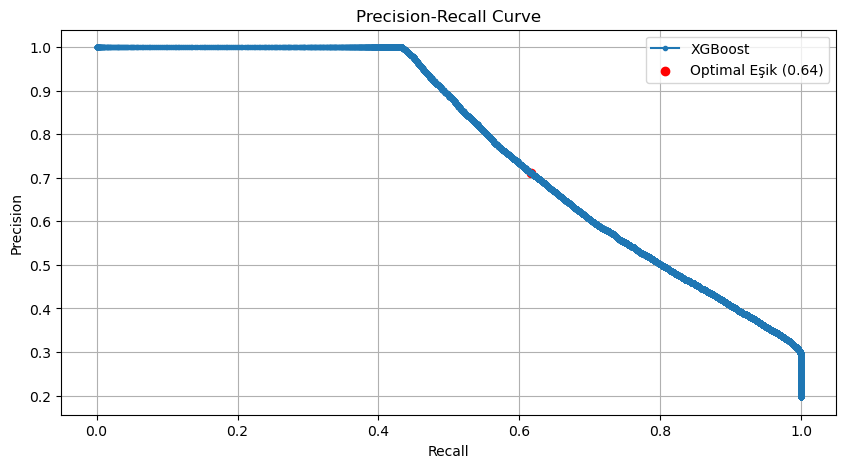


--- FINAL RESULTS WITH OPTIMAL THRESHOLD VALUE ---
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     63671
           1       0.71      0.62      0.66     15535

    accuracy                           0.88     79206
   macro avg       0.81      0.78      0.79     79206
weighted avg       0.87      0.88      0.87     79206



In [23]:
probabilities = best_xgb_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probabilities)
f1_scores = (2 * precisions * recalls) / (precisions + recalls)

f1_scores = f1_scores[:-1]

best_f1_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_f1_idx]

print(f"The optimal threshold value that yields the best F1-Score: {optimal_threshold:.4f}")
print(f"The F1-Score at this threshold: {f1_scores[best_f1_idx]:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(recalls, precisions, marker='.', label='XGBoost')

plt.scatter(recalls[best_f1_idx], precisions[best_f1_idx], marker='o', color='red', label=f'Optimal Eşik ({optimal_threshold:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

y_pred_final = (probabilities >= optimal_threshold).astype(int)

print("\n--- FINAL RESULTS WITH OPTIMAL THRESHOLD VALUE ---")
print(classification_report(y_test, y_pred_final))
